### Lab 5: Higgs Classification

#### The Large Hadron Collider

The Large Hadron Collider (LHC) is used in experiments where particles are accelerated to relativistic speeds and then collided. Upon collision, atomic particles release their subatomic components. One of these subatomic particles is the Higgs boson, which is created when the energy released by the collision is sufficiently large. However, due to large background contamination of other quantum chromodynamic particles (QCD), a direct 5-sigma observation of Higgs boson jets has not yet been accomplished. In order to improve our ability to detect Higgs boson jets, we will use a series of training datasets which mimic the data output of the Large Hadron Collider to optimize a discriminator and select events to enhance discovery sensitivity.

#### How the LHC Differentiates Particles

The LHC has four sections of detectors. The tracking chamber detects charged particles, the electromagnetic calorimeter interacts with protons and electrons, the hadronic calorimeter interacts with hadrons like pions and protons, and the muon chamber is reserved for particles which pass through all other detectors. The two calorimeters essentially filter out high energy particles and only allow relatively low energy particles to pass through. By counting the particles in these decay chains, the total energy of the original particle can be uncovered.

#### What is a Jet?

A jet is a collection of particles that go towards the same direction in the detector. Intuitively, they come from 'showering' and the fragmentation of a primordial hard quark or gluon. In practice, jets must be defined from experimental observables, such as the 4-momenta of observed particles in the event.

When particles are recorded by the calorimeters, they create detection clusters which depend on their original quark or gluon. In order to determine the original quark or gluon these detections came from, we must group them together. These jets can then be given characterstic values like mass, angular information, transverse momentum, and substructure variables which describe the shape of the jet.

#### Sub-Jetting

Sometimes a jet can split into multiple distinct jets corresponding to seperate cluons or quarks. This is caused by the decay of a boson which creates highly collimated particles which in turn create seperate jets that are close to one another. We can identify this phenomenon numerically by grouping a single jet into multiple sub-jets and finding the average distance to each sub-jet from the detector. By increasing the number of sub-jets, the average distance will always decrease, so by taking the ratio of the average distance for N sub-jets and the average distance for n-1 sub-jets, the number of independant sub-jets can be found.

#### Understanding the Data

| pt  | eta | phi | mass | ee2 | ee3 | d2  | angularity | t1  | t2  | t3  | t21 | t32 | KtDeltaR |
|-----|-----|-----|------|-----|-----|-----|------------|-----|-----|-----|-----|-----|----------|
| ... | ... | ... | ...  | ... | ... | ... | ...        | ... | ... | ... | ... | ... | ...      |


    -pt: The transverse momentum of a jet
    -eta: Rapidity, which is a function of angle theta which goes to plus or minus infinity along the beam axis
    -phi: The Azimuthal angle of the jet
    -mass: The total mass of the jet
    -ee2: A 2 point correlation function measuring the energy of the jet.
    -ee3: A 2 point correlation function measuring the energy of the jet.
    -d2: The ratio of ee3:ee2
    -angularity: Describes how symetric the decay is, where a smaller angularity indicates higher symmetry.
    -t1: Average distance from jets with 1 sub-jet
    -t2: Average distance from jets with 2 sub-jets
    -t3: Average distance from jets with 3 sub-jets
    -t21: The ratio of t2:t1
    -t32 The ratio of t3:t2
    -KtDeltaR: The radius of the jets, which measures how clustered or close together the detected jets are.

In [16]:
import pickle
import math
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

In [21]:
qcd_file = open("qcd_100000_pt_1000_1200.pkl", 'rb')
qcd_d = pickle.load(qcd_file)

higgs_file = open("higgs_100000_pt_1000_1200.pkl", 'rb')
higgs_d = pickle.load(higgs_file)

features = [key for key in qcd.keys()]
print(features)

['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR']


Our first step will be to determine which features provide a high discrimination potential between the theoretical Higgs boson jet and background QCD contamination. In order to discover this, we will plot the two via comparative histograms for each feature.

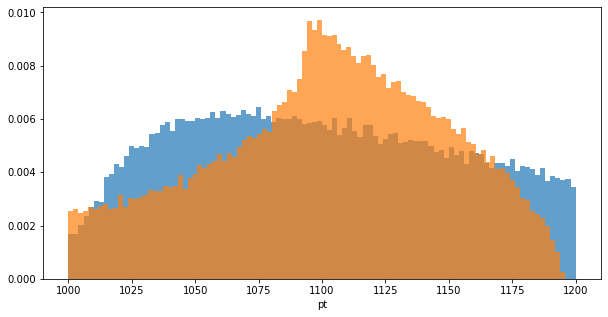

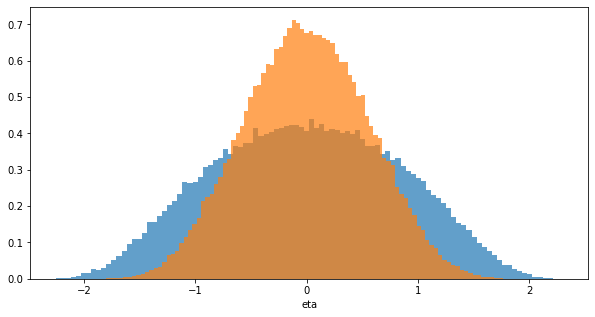

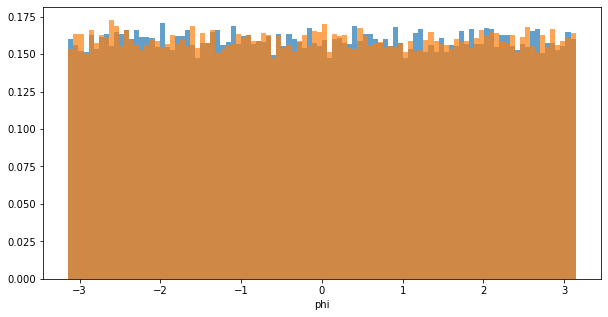

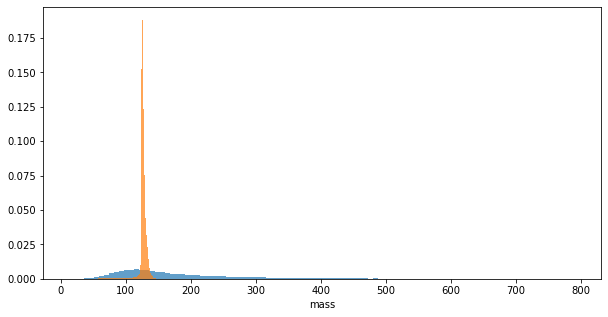

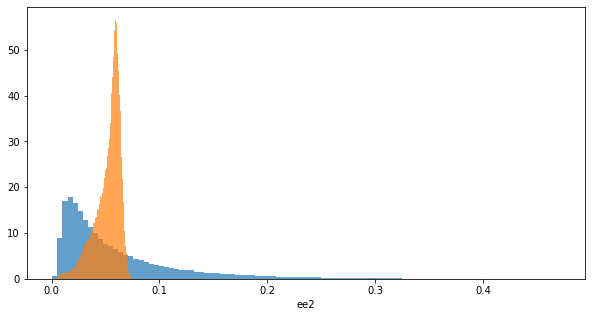

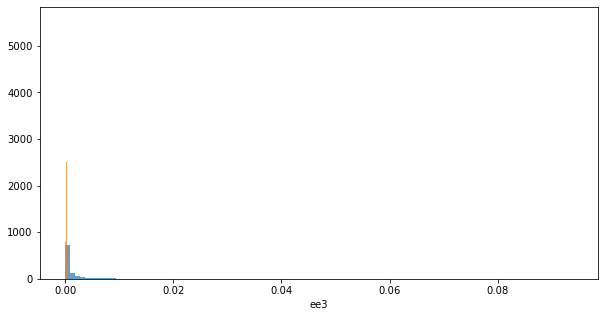

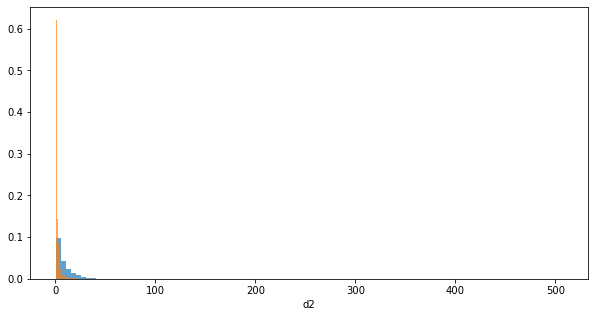

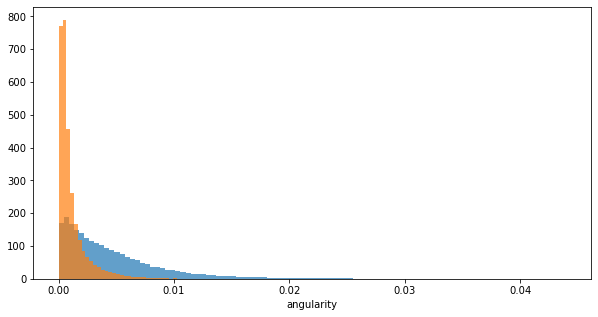

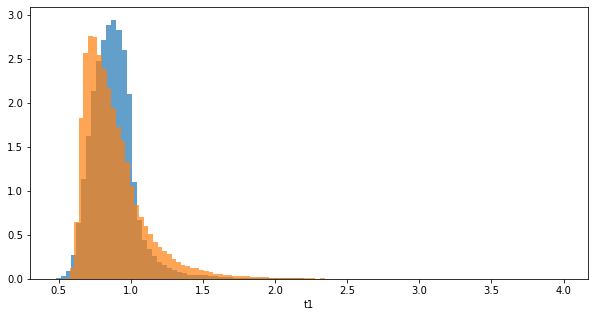

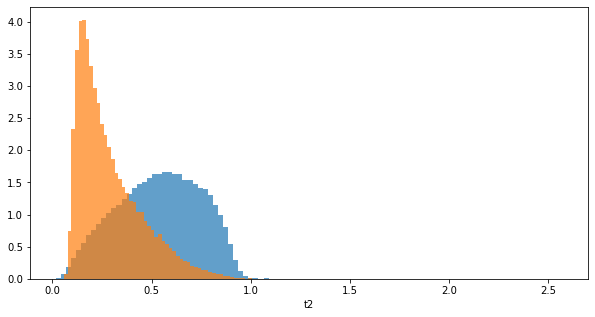

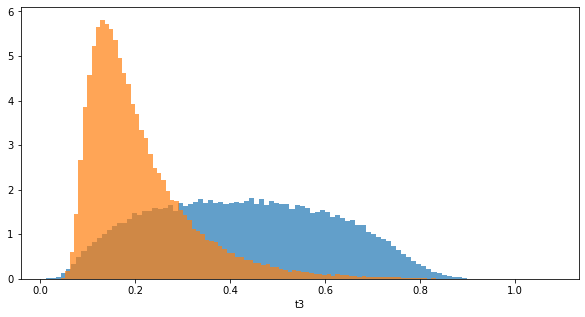

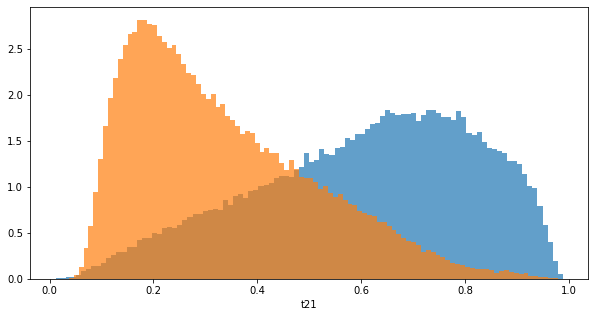

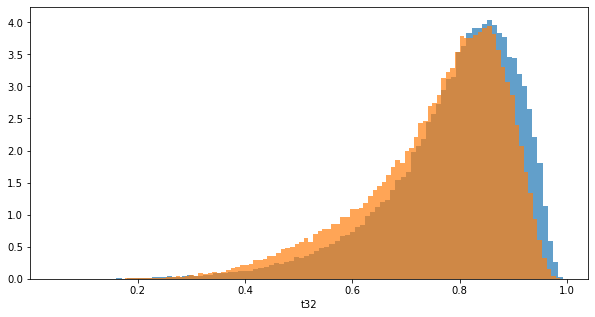

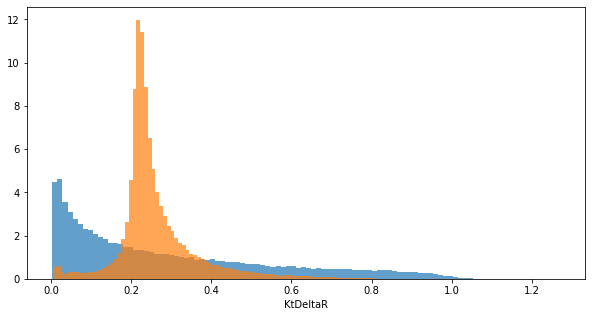

In [38]:
for i in range(0,14):
    plt.hist(qcd[features[i]], density=True, bins=100, alpha=0.7, label='QCD')
    plt.hist(higgs[features[i]], density=True, bins=100, alpha=0.7, label='Higgs')
    plt.xlabel(features[i])
    plt.show()

The histograms above compare each feature of the Higgs jets vs. the feature of the QCD jets. By visual inspection, it appears that mass, ee2, ee3, d2, angularity, t2, t3, t21, and KtDeltaR provide strong discrimination power between signal and background. By comparison, pt, eta, and t1 provide weak discrimination power, and phi and t32 provide no discrimination power.

To discover the correlations among the features, we will create a correlation table, and then summarize it to identify the most highly correlated features.

In [31]:
ctable = qcd_d.corr()
ctable

,pt,eta,phi,mass,ee2,ee3,d2,angularity,t1,t2,t3,t21,t32,KtDeltaR
pt,1.000000,0.000083,-0.006469,0.095461,0.012772,0.006981,-0.003817,0.032309,-0.010783,-0.027798,-0.033102,-0.027596,-0.024690,0.024390
eta,0.000083,1.000000,0.001784,0.000767,0.000499,0.001447,-0.002371,0.000908,-0.002803,-0.001568,-0.001840,-0.000351,-0.000405,-0.002086
phi,-0.006469,0.001784,1.000000,-0.005159,-0.003282,-0.003464,0.001273,-0.008891,0.002601,0.000465,0.001326,-0.000321,0.002848,-0.003087
mass,0.095461,0.000767,-0.005159,1.000000,0.959965,0.793991,-0.538750,0.529638,0.010450,-0.533355,-0.621826,-0.585519,-0.459640,0.708356
ee2,0.012772,0.000499,-0.003282,0.959965,1.000000,0.844699,-0.567445,0.427854,0.126657,-0.517926,-0.620038,-0.613574,-0.495083,0.614471
ee3,0.006981,0.001447,-0.003464,0.793991,0.844699,1.000000,-0.306321,0.433308,0.138780,-0.250764,-0.350501,-0.323984,-0.412092,0.459877
d2,-0.003817,-0.002371,0.001273,-0.538750,-0.567445,-0.306321,1.000000,-0.184381,-0.022127,0.554533,0.622112,0.619491,0.325022,-0.392433
angularity,0.032309,0.000908,-0.008891,0.529638,0.427854,0.433308,-0.184381,1.000000,-0.052497,-0.152266,-0.196199,-0.155062,-0.190053,0.406357
t1,-0.010783,-0.002803,0.002601,0.010450,0.126657,0.138780,-0.022127,-0.052497,1.000000,0.326725,0.238284,-0.002957,-0.146209,-0.271773
t2,-0.027798,-0.001568,0.000465,-0.533355,-0.517926,-0.250764,0.554533,-0.152266,0.326725,1.000000,0.936640,0.926364,0.129887,-0.635300


In [29]:
a = (ctable-np.eye(len(ctable))).max()
b = (ctable-np.eye(len(ctable))).idxmax()
pd.DataFrame([a,b]).T

,0,1
pt,0.0954613,mass
eta,0.00178366,phi
phi,0.00284771,t32
mass,0.959965,ee2
ee2,0.959965,mass
ee3,0.844699,ee2
d2,0.622112,t3
angularity,0.529638,mass
t1,0.326725,t2
t2,0.93664,t3


As we can see, mass and ee2, t2 and t3, and t21 and t2 are all highly correlated.

In order to determine the signifcance of the deviation in the Higgs observations vs. the background, we will use CLT to find the population mean and standard deviation for each.

In [68]:
samplesize = 2000
samples = 200
qcdSamples = {}
higgsSamples = {}
bgMean = {}
bgStd = {}

for feature in features:
    for s in range(0,samples):
        qcdsample = np.random.choice(qcd[feature], samplesize, replace=True)
        higgssample = np.random.choice(higgs[feature], samplesize, replace=True)
        if feature not in qcdSamples:
            qcdSamples[feature] = {"mean": [np.mean(qcdsample)], "std": [np.std(qcdsample)]}
            higgsSamples[feature] = {"mean": [np.mean(higgssample)], "std": [np.std(higgssample)]}
        else:
            qcdSamples[feature]["mean"].append(np.mean(qcdsample))
            qcdSamples[feature]["std"].append(np.std(qcdsample))
            qcdSamples[feature]["mean"].append(np.mean(higgssample))
            qcdSamples[feature]["std"].append(np.std(higgssample))
    bgMean[feature] = np.mean(qcdSamples[feature]["mean"])
    bgStd[feature] = np.std(qcdSamples[feature]["std"])/sqrt(samplesize)

In [79]:
sigmas = {}
for feature in features:
    p = stats.norm.cdf(higgsSamples[feature]["mean"], loc=bgMean[feature], scale =bgStd[feature])
#     print(feature , "p = ", p)
    sigmas[feature] = stats.norm.ppf(p)
    print(feature , "s = ", stats.norm.ppf(p))
# Discovery Sensitivities

pt s =  [0.35854221]
eta s =  [-0.0276469]
phi s =  [-1.28343309]
mass s =  [-0.54721931]
ee2 s =  [-0.19731861]
ee3 s =  [-0.37925551]
d2 s =  [-1.05336693]
angularity s =  [-1.13178138]
t1 s =  [0.01098083]
t2 s =  [-5.16789278]
t3 s =  [-2.84252369]
t21 s =  [-7.80535994]
t32 s =  [-3.31949914]
KtDeltaR s =  [-0.17835164]


It seems that our best strategy to discriminate between QCD particles and the Higgs boson will be to examine the features t2 and t21, which have the highest sensitivity by far compared to the other features. In order to use these to better differentiate the two types of particles, we may want to focus on detecting a subset of all detections which contains the average t2 value for a Higgs boson jet (approx 0.2) but excludes the average value for the background (approx 0.6).